# Caelan Osman
# Homework 13.2
# Feb. 17, 2022

## Exercise 13.3

In [1]:
import numpy as np
from filterpy.kalman import KalmanFilter
from matplotlib import pyplot as plt

In [2]:
# Helper function
def filter(f, zs): # filter using each observation
    n = np.size(zs,0)
    # initialize
    xhat = np.zeros((n,f.dim_x,1))
    Ps = np.zeros((n,f.dim_x,f.dim_x))

    for i,z in enumerate(zs):
        f.predict()
        f.update(z)
        xhat[i] = f.x.copy()
        Ps[i] = f.P.copy()

    return xhat, Ps

### Kalman filter for the constant water system

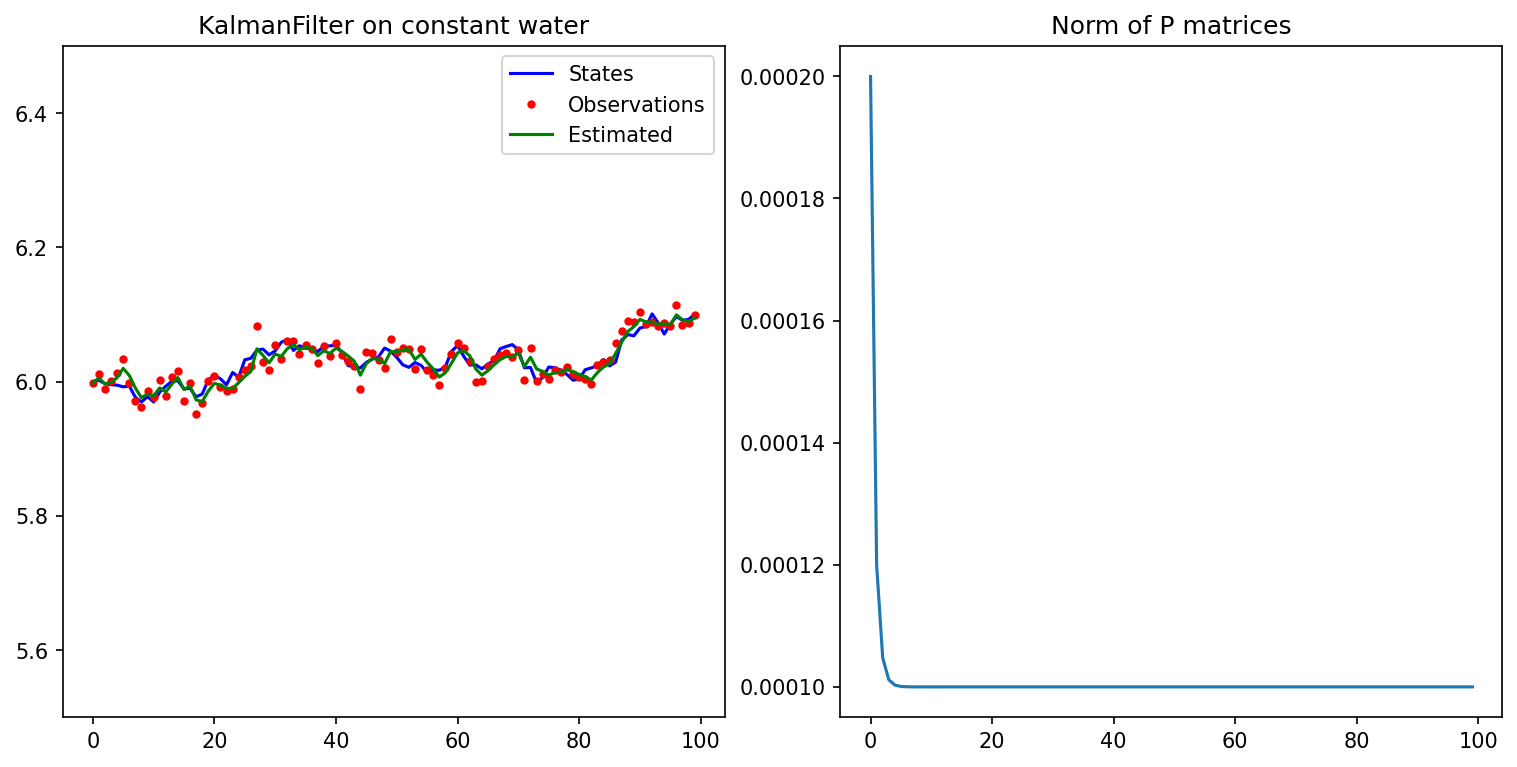

In [3]:
def filter_constant_water():

    def evolve_constant_water(x0, Q, R, steps=100):
        # state state and observation arrays
        states = np.zeros(steps)
        obs = np.zeros_like(states)
        # set initial points
        states[0] = x0
        v = np.random.multivariate_normal(mean=np.zeros(1), cov=R)[0]
        obs[0] = x0 + v
    
        # iterate through and add states and noise
        for k in range(1, steps):
            w = np.random.multivariate_normal(mean=np.zeros(1), cov=Q)[0]
            states[k] = states[k-1] + w
            v = np.random.multivariate_normal(mean=np.zeros(1), cov=R)[0]
            obs[k] = states[k] + v
        
        return states, obs

    x0 = 6
    Q = 0.0001*np.eye(1)
    R = 0.0002*np.eye(1)
    states, obs = evolve_constant_water(x0, Q, R)

    n = 100
    x0hat = np.array([x0]) # Initial guess of the -state
    u = np.zeros(n) # No control
    P = np.eye(1) # Initial estimator -covariance

    # instantiate the filter
    kf = KalmanFilter(dim_x=1,dim_z=1)
    #define the system
    kf.F = np.eye(1) # State transition
    kf.G = np.eye(1) # Control matrix
    kf.Q = Q # Covar of state -transition
    kf.H = np.eye(1) # Observation matrix
    kf.R = R # Covar of observation

    # Set the starting values
    kf.x = x0hat.reshape(-1, 1) # shape matters
    kf.P = P

    # filter
    xhat, ps = filter(kf, obs)
    xhat = xhat.flatten()
    P_norm = [np.linalg.norm(ps[i]) for i in range(n) ]

    #plot
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
    fig.set_dpi(150)
    ax = axs[0]
    ax.plot(states, 'b-', label='States')
    ax.plot(obs, 'r.', label='Observations')
    ax.plot(xhat, 'g-', label='Estimated')
    ax.legend(loc='best')
    ax.set_ylim([5.5, 6.5])
    ax.set_title('KalmanFilter on constant water')
    ax = axs[1]
    ax.plot(P_norm)
    ax.set_title('Norm of P matrices')
    plt.show()
    return

filter_constant_water()

The kalman filter has done a pretty good job estimating the states.
The norms look like they're converging to zero.

### Kalman filter for the varying water level system

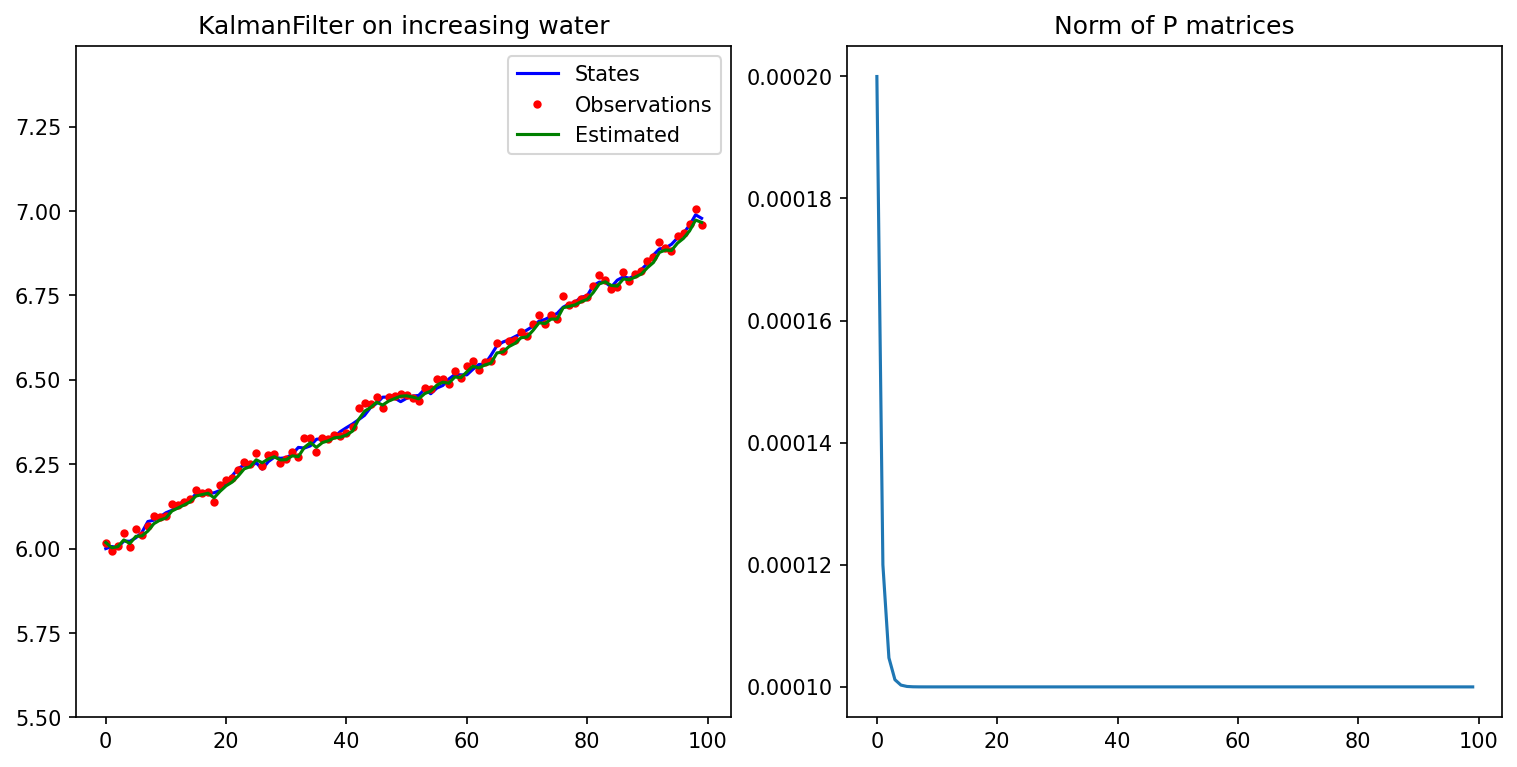

In [4]:
def filter_varying_water():

    def evolve_non_constant_water(x0, c, Q, R, steps=100):
        # initialize and set states
        states = np.zeros(steps)
        obs = np.zeros_like(states)
        states[0] = x0
        v = np.random.multivariate_normal(mean=np.zeros(1), cov=R)[0]
        obs[0] = states[0] + v
        # iterate through and create states and observations
        for k in range(1, steps):
            w = np.random.multivariate_normal(mean=np.zeros(1), cov=Q)
            states[k] = states[k-1] + c + w
            v = np.random.multivariate_normal(mean=np.zeros(1), cov=R)[0]
            obs[k] = states[k] + v

        return states, obs

    x0 = 6
    c = 0.01
    Q = 0.0001*np.eye(1)
    R = 0.0002*np.eye(1)
    states, obs = evolve_non_constant_water(x0, c, Q, R)

    n = 100
    x0hat = np.array([x0]) # Initial guess of the -state
    u = c*np.ones(n) # flow rate is control
    P = np.eye(1) # Initial estimator -covariance
    # instantiate the filter
    kf = KalmanFilter(dim_x=1, dim_z=1)
    #define the system
    kf.F = np.eye(1) # State transition
    kf.G = np.eye(1) # Control matrix
    kf.Q = Q # Covar of state -transition
    kf.H = np.eye(1) # Observation matrix
    kf.R = R # Covar of observation

    # Set the starting values
    kf.x = x0hat.reshape(-1,1) # shape matters
    kf.P = P

    # filter
    xhat, ps = filter(kf, obs)
    xhat = xhat.flatten()
    P_norm = [np.linalg.norm(ps[i]) for i in range(n) ]

    # plot
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
    fig.set_dpi(150)
    ax = axs[0]
    ax.plot(states, 'b-', label='States')
    ax.plot(obs, 'r.', label='Observations')
    ax.plot(xhat, 'g-', label='Estimated')
    ax.legend(loc='best')
    ax.set_ylim([np.min(states)- 0.5, np.max(states) + 0.5])
    ax.set_title('KalmanFilter on increasing water')
    ax = axs[1]
    ax.plot(P_norm)
    ax.set_title('Norm of P matrices')
    plt.show()
    return

filter_varying_water()

The kalman filter has done a pretty good job estimating the states.
The norms look like they're converging to zero.

### Kalman filter for the idealized spring system

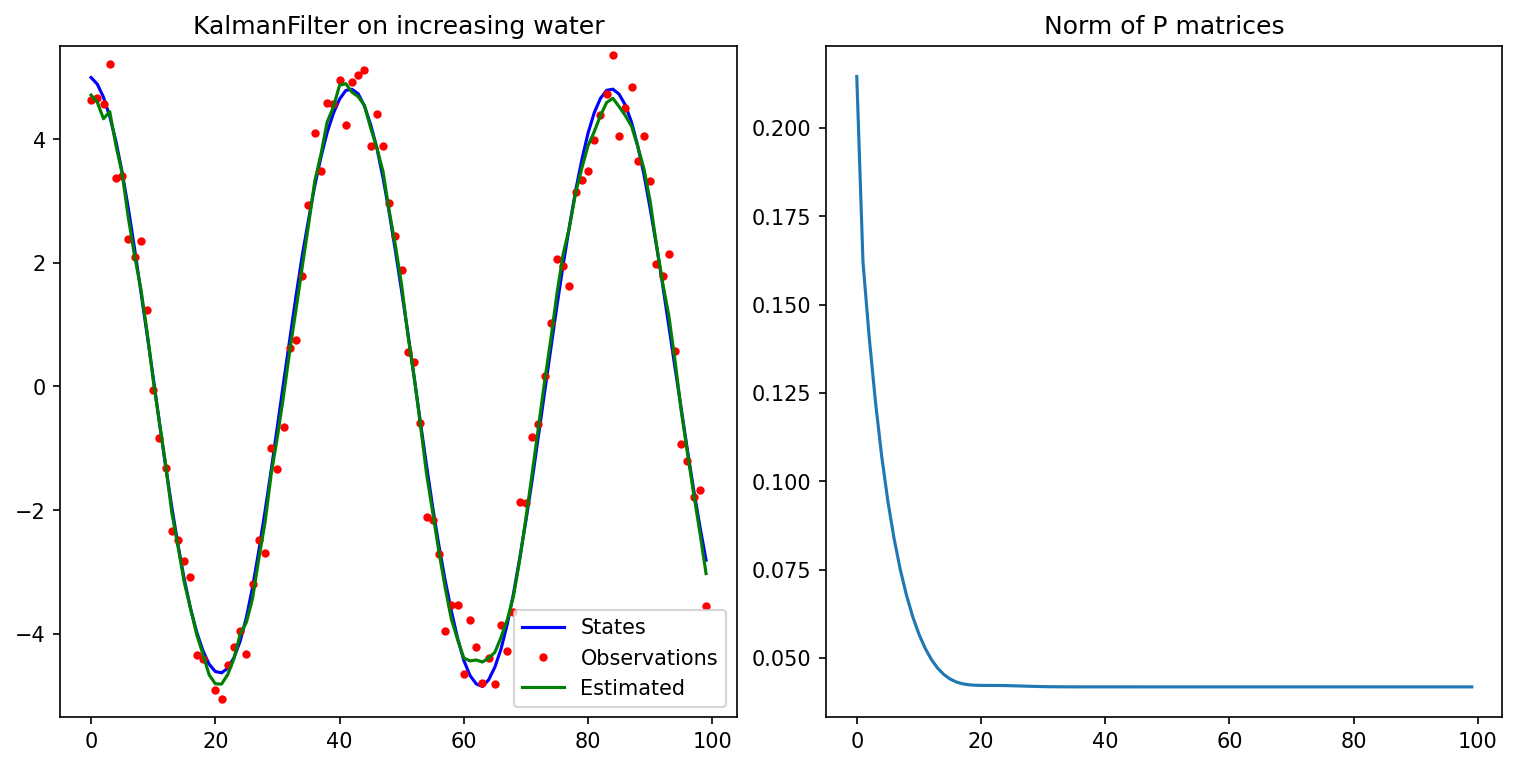

In [5]:
def filter_spring(evolve_only=False):

    def evolve_spring(x0, w, delta_t, Q, R, steps=100):
        F = np.array([[2 - w**2*delta_t**2, -1],
                  [1, 0]])
    
        states = np.zeros((steps, x0.size))
        obs = np.zeros_like(states)
        states_mean = np.zeros(Q.shape[0])
        obs_mean =  np.zeros(R.shape[0])
        states[0] = x0
        v = np.random.multivariate_normal(mean=obs_mean, cov=R)
        obs[0] = x0 + v

        for k in range(1, steps):
            v = np.random.multivariate_normal(mean=states_mean, cov=Q)
            states[k] = F@states[k-1] + v
            w = np.random.multivariate_normal(mean=obs_mean, cov=R)
            obs[k] = states[k] + w

        return states, obs

    x0 = np.array([5, 5])
    w = 15
    delta_t = 0.01
    Q = 0.0001*np.eye(2)
    R = 0.2*np.eye(2)
    F1 = np.array([[2 - w**2*delta_t**2, -1],
                  [1, 0]])

    states, obs = evolve_spring(x0, w, delta_t, Q, R)

    if evolve_only:
        return states, obs

    n = 100
    x0hat = x0 # Initial guess of the -state
    u = np.zeros(n) # No control
    P = np.eye(2) # Initial estimator -covariance
    # instantiate the filter
    kf = KalmanFilter(dim_x=2, dim_z=2)
    #define the system
    kf.F = F1 # State transition
    kf.G = np.eye(2) # Control matrix
    kf.Q = Q # Covar of state -transition
    kf.H = np.eye(2) # Observation matrix
    kf.R = R # Covar of observation

    # Set the starting values
    kf.x = x0hat.reshape(-1,1) # shape matters
    kf.P = P
    # filter
    xhat, ps = filter(kf, obs)
    xhat = xhat[:, 0, 0]
    P_norm = [np.linalg.norm(ps[i]) for i in range(n) ]
    # plot
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
    fig.set_dpi(150)
    ax = axs[0]
    ax.plot(states[:, 0], 'b-', label='States')
    ax.plot(obs[:, 0], 'r.', label='Observations')
    ax.plot(xhat, 'g-', label='Estimated')
    ax.legend(loc='best')
    ax.set_ylim([np.min(states) - 0.5, np.max(states) + 0.5])
    ax.set_title('KalmanFilter on increasing water')
    ax = axs[1]
    ax.plot(P_norm)
    ax.set_title('Norm of P matrices')
    plt.show()
    return

    return
filter_spring()

The kalman filter has done a pretty good job estimating the states.
The norms look like they're converging to zero.

### part 2 and part 3

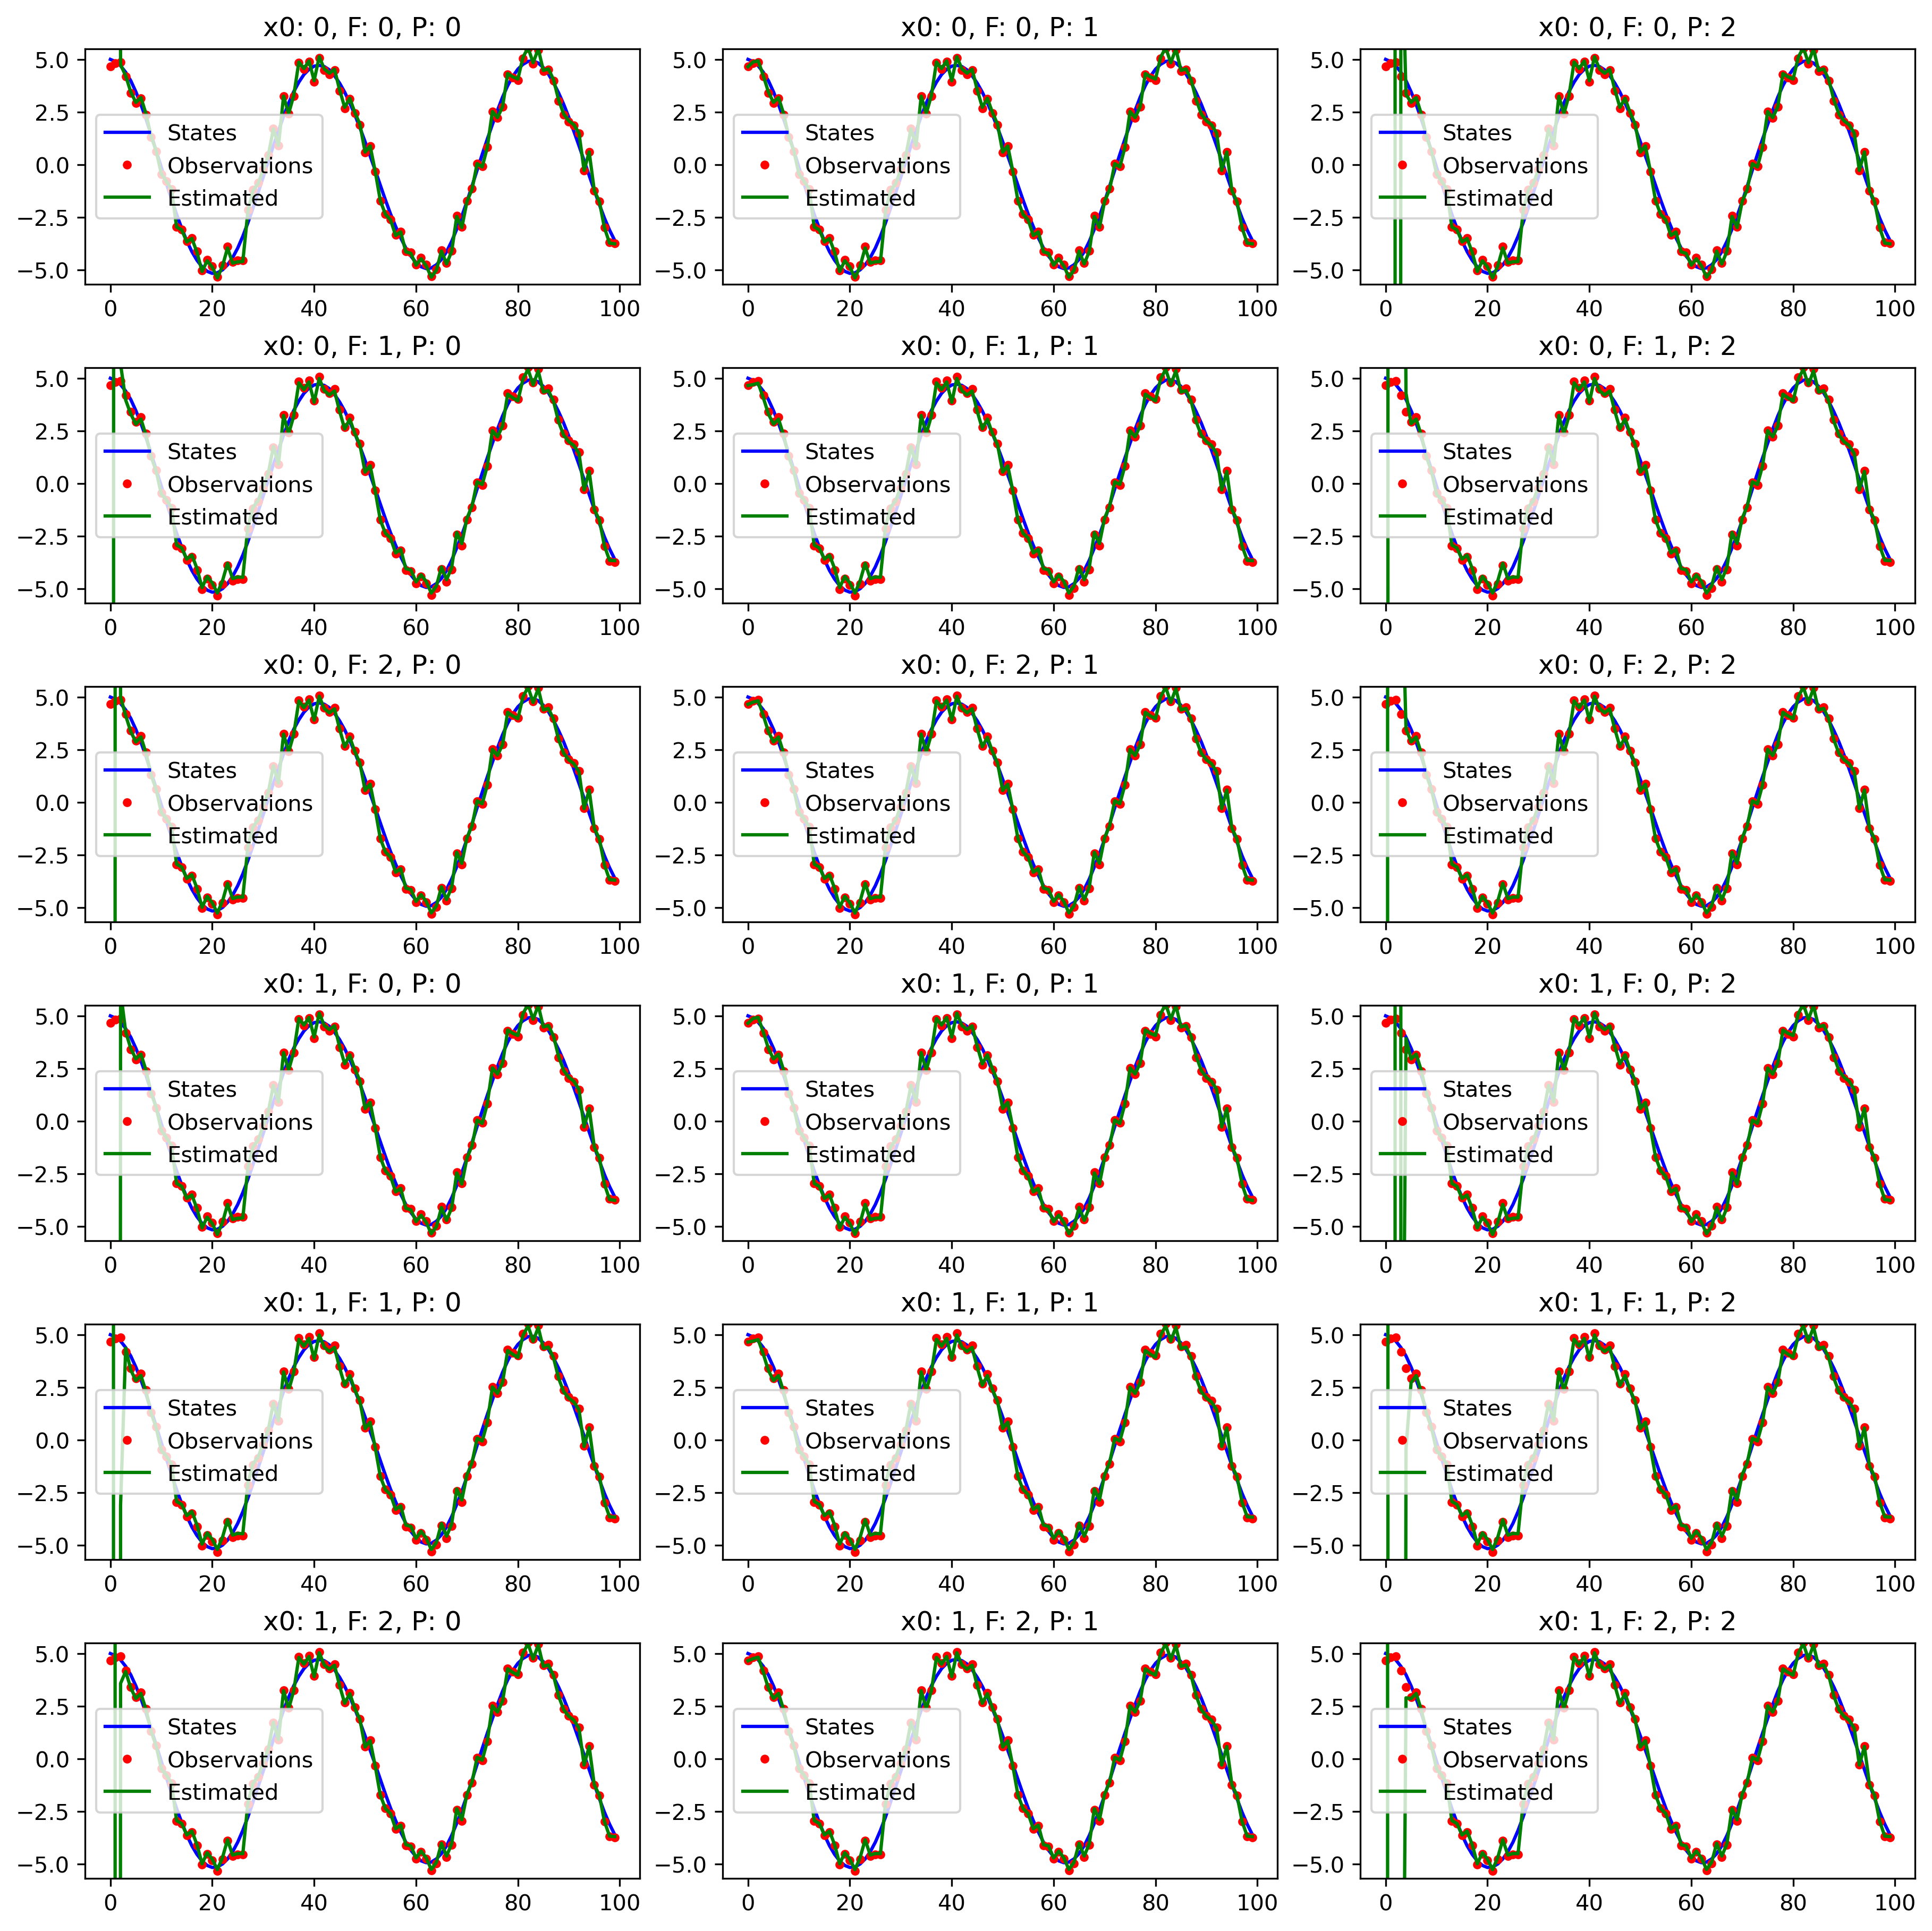

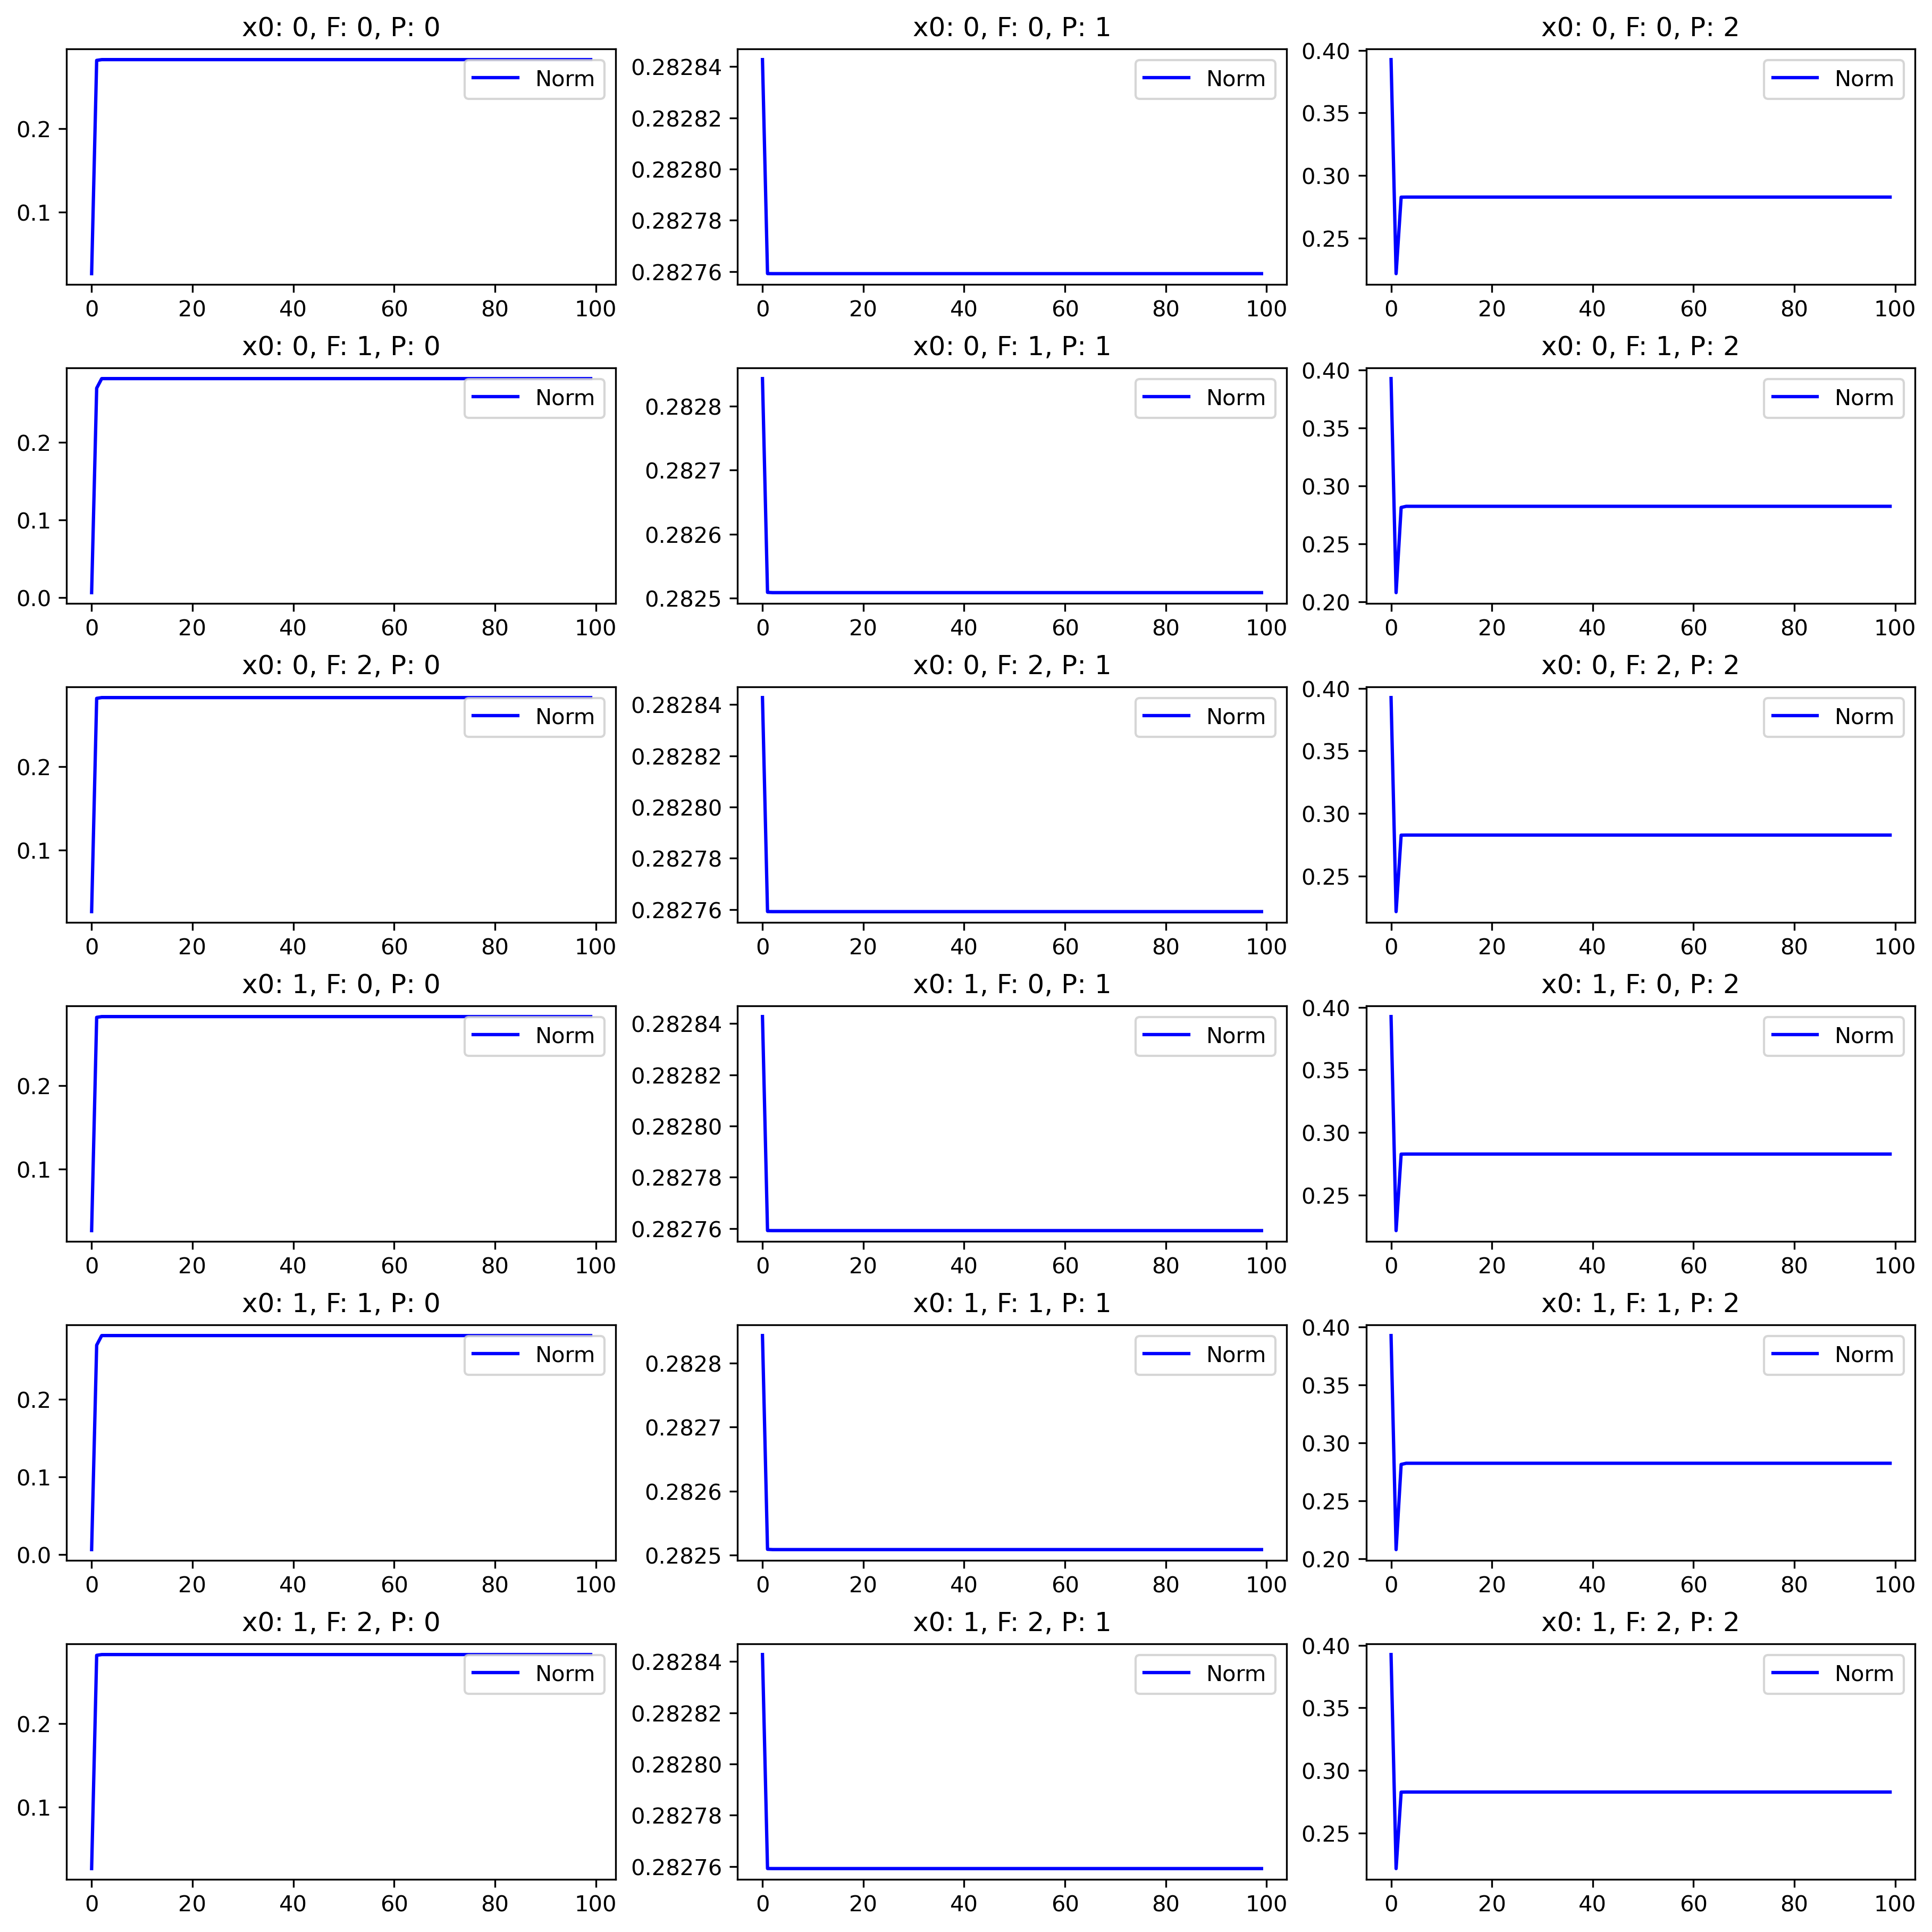

In [6]:
def comparisons():


    states, obs =  filter_spring(evolve_only=True)
    #set up plot
    fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(12, 12))
    fig.set_dpi(300)
    # set up parameters
    w = 15
    delta_t = 0.01
    Q = 0.0001*np.eye(2)
    R = 0.2*np.eye(2)
    F1 = np.array([[2 - w**2*delta_t**2, -1],
                   [1, 0]])

    x0s = [np.array([-5, 2]),
           np.array([20, -3])]
    Ps = [np.arange(1, 5).reshape(2, 2)/(1e6),
          150*np.arange(1, 9, 2).reshape(2, 2),
          np.logspace(0, 1, 4).reshape(2, 2)]
    Fs = [F1*-100, F1*50,  F1*100]

    n = 100
    k = 0
    u = np.zeros(n) # No control
    norms = []
    for j, x0 in enumerate(x0s):
        for m, F in enumerate(Fs):
             for i, P in enumerate(Ps):

                # instantiate the filter
                kf = KalmanFilter(dim_x=2, dim_z=2)
                #define the system
                kf.F = F # State transition
                kf.G = np.eye(2) # Control matrix
                kf.Q = Q # Covar of state -transition
                kf.H = np.eye(2) # Observation matrix
                kf.R = R # Covar of observation

                # Set the starting values
                kf.x = x0.reshape(-1,1) # shape matters
                kf.P = P
                # filter
                xhat, ps = filter(kf, obs)
                xhat = xhat[:, 0, 0]
                P_norm = [np.linalg.norm(ps[i]) for i in range(n) ]
                norms.append(P_norm)

                ax = axs[k, i]
                ax.plot(states[:, 0], 'b-', label='States')
                ax.plot(obs[:, 0], 'r.', label='Observations')
                ax.plot(xhat, 'g-', label='Estimated')
                ax.legend(loc='best')
                ax.set_title('x0: ' + str(j) + ', F: ' + str(m) + ', P: ' + str(i))
                ax.set_ylim([np.min(states) - 0.5, np.max(states) + 0.5])
                if i == 2:
                    k += 1

    plt.show()

    # now plot the norms
    fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(12, 12))
    fig.set_dpi(300)
    n = 0
    k = 0
    for j, x0 in enumerate(x0s):
        for m, F in enumerate(Fs):
            for i, P in enumerate(Ps):

                ax = axs[k, i]
                ax.plot(norms[n], 'b-', label='Norm')
                ax.legend(loc='best')
                ax.set_title('x0: ' + str(j) + ', F: ' + str(m) + ', P: ' + str(i))

                if i == 2:
                    k += 1
                n += 1

    plt.show()
    return

comparisons()

Surprisingly, even with very bad model parameters, the Kalman filter in my case often times still did a decent job of estimating the states.
The covriance matrices eventually "burned in" but more often than not, the norms never converged to zero.
The covariance matrices didn't converge to zero because they were tring to adjust for the bad model parameters.